In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv(r"C:\Users\athud\Data Science\Capstone self driving project\driving_log.csv",  header=None, names = ["center", "left", "right", "steering", "speed", "throttle", "break"])

In [3]:
data.head()

,center,left,right,steering,speed,throttle,break
0,C:\Users\athud\Data Science\Capstone self driv...,C:\Users\athud\Data Science\Capstone self dri...,C:\Users\athud\Data Science\Capstone self dri...,0.0,0.0,0.0,0.000078
1,C:\Users\athud\Data Science\Capstone self driv...,C:\Users\athud\Data Science\Capstone self dri...,C:\Users\athud\Data Science\Capstone self dri...,0.0,0.0,0.0,0.000078
2,C:\Users\athud\Data Science\Capstone self driv...,C:\Users\athud\Data Science\Capstone self dri...,C:\Users\athud\Data Science\Capstone self dri...,0.0,0.0,0.0,0.000078
3,C:\Users\athud\Data Science\Capstone self driv...,C:\Users\athud\Data Science\Capstone self dri...,C:\Users\athud\Data Science\Capstone self dri...,0.0,0.0,0.0,0.000078
4,C:\Users\athud\Data Science\Capstone self driv...,C:\Users\athud\Data Science\Capstone self dri...,C:\Users\athud\Data Science\Capstone self dri...,0.0,0.0,0.0,0.000084


## Since we are making the model to have the center image and stearng angle only

In [4]:
image_paths = []
steering_angles = []

# Assuming your images are in the same folder or adjust accordingly
image_folder = r'C:\Users\athud\Data Science\Capstone self driving project\IMG'

for i in range(len(data)):
    center_image_path = os.path.join(image_folder, os.path.basename(data['center'][i].strip()))
    image_paths.append(center_image_path)
    steering_angles.append(data['steering'][i])

print(f"Total samples loaded: {len(image_paths)}")

Total samples loaded: 2622


In [5]:
from PIL import Image
from IPython.display import display
from PIL import ImageDraw

image_index = 55 #Edit this value to see diffrent images and their steering angles

img = Image.open(image_paths[image_index])
I1 = ImageDraw.Draw(img)
I1.text((28, 36),f"{steering_angles[image_index]}", fill=(225, 0, 0))
img.show()

## Resizing image to standard size

import cv2
import os

# Folder paths
input_folder = r'C:\Users\athud\Data Science\Capstone self driving project\IMG'
output_folder = r'C:\Users\athud\Data Science\Capstone self driving project\IMG'

os.makedirs(output_folder, exist_ok=True)

for img_file in os.listdir(input_folder):
    img_path = os.path.join(input_folder, img_file)
    image = cv2.imread(img_path)
    
    # Resize to (200 width, 66 height)
    resized = cv2.resize(image, (200, 66))
    
    output_path = os.path.join(output_folder, img_file)
    cv2.imwrite(output_path, resized)


## Build the Model

In [ ]:
# Step 1: Import Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Lambda, Dropout

In [8]:
# Step 2: Define the Model
model = Sequential()

# Normalization Layer
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))

C:\Users\athud\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Convolution Layers
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [10]:
# Flattening
model.add(Flatten())

In [11]:
# Fully Connected Layers
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))  # 50% neurons turned off randomly during training
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))  # Final output: steering angle (single number)

## Data Generator

In [12]:
import numpy as np
import cv2
import sklearn
from sklearn.utils import shuffle

def data_generator(image_paths, steering_angles, batch_size=32, is_training=True):
    num_samples = len(image_paths)
    
    while True:  # Loop forever so the generator never terminates
        image_paths, steering_angles = shuffle(image_paths, steering_angles)
        
        for offset in range(0, num_samples, batch_size):
            batch_images = image_paths[offset:offset+batch_size]
            batch_steering = steering_angles[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for image_path, angle in zip(batch_images, batch_steering):
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Resize to (200x66)
                image = cv2.resize(image, (200, 66))
                
                images.append(image)
                angles.append(angle)
                
            X = np.array(images)
            y = np.array(angles)
            
            yield X, y


In [13]:
model.compile(loss='mse', optimizer='adam')

In [14]:
batch_size = 32

train_generator = data_generator(image_paths, steering_angles, batch_size=batch_size)

steps_per_epoch = len(image_paths) // batch_size

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    verbose=1)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 72s 734ms/step - loss: 0.0339
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0273
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0289
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0274
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0238
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0233
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0236
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0214
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0216
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0235


## Loss graph

In [15]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    verbose=1)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0220
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0222
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0198
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0181
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0180
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0155
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0147
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0147
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0115
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0100


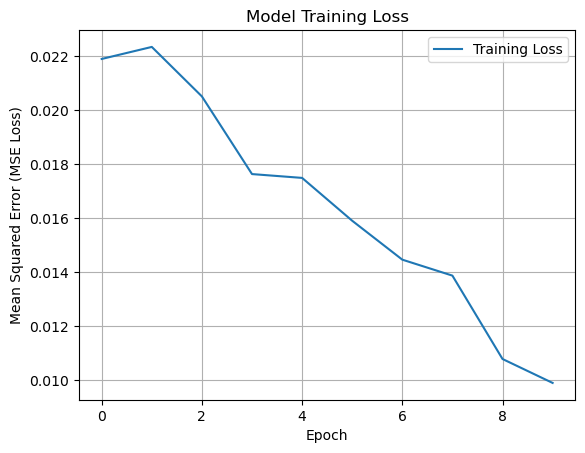

In [16]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Mean Squared Error (MSE Loss)')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.grid(True)
plt.show()

##### SAVING MODEL

In [22]:
keras.saving.save_model(model, 'my_model1.h5')

In [24]:
keras.saving.save_model(model, 'my_model.keras')

In [17]:
from tensorflow.keras.models import load_model
import keras

# Allow unsafe deserialization
keras.config.enable_unsafe_deserialization()

# Now load the model
model = load_model("my_model.keras")

C:\Users\athud\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
from tensorflow.keras.models import load_model

model = load_model("my_model.keras")

In [19]:
# Load image
image = cv2.imread(r"C:\Users\athud\Data Science\Capstone self driving project\Backup images\IMG\center_2025_04_26_15_12_12_165.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize to (200x66) because model expects this input
image = cv2.resize(image, (200, 66))

# Expand dimensions because model expects a batch (even if single image)
image = np.expand_dims(image, axis=0)

# Predict
steering_angle = model.predict(image)

print(f"Predicted Steering Angle: {steering_angle[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
Predicted Steering Angle: 0.017550529912114143


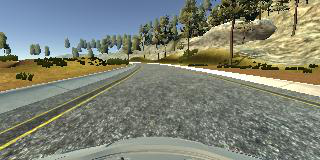

In [20]:
display(Image.open(r"C:\Users\athud\Data Science\Capstone self driving project\Backup images\IMG\center_2025_04_26_15_12_12_165.jpg"))

## Build a simple Test Dashboard 🚗✨

This dashboard will:

1. Load multiple test images

2. Predict the steering angle for each

3. Show the image + predicted angle together

4. Plot everything in a clean visual grid